In [39]:
from PIL import Image
from typing import TypedDict, List, Optional
from langgraph.graph import StateGraph, END
from langchain_google_genai import (
    ChatGoogleGenerativeAI,
    GoogleGenerativeAIEmbeddings
)
from langchain_core.documents import Document
from qdrant_client import QdrantClient
from PIL import Image
from qdrant_client import models
from langgraph.graph import StateGraph, END
import json

In [40]:
import os
from dotenv import load_dotenv

load_dotenv()

GEMINI_KEY = os.getenv("GEMINI_PAID_KEY")

In [41]:
gemini = ChatGoogleGenerativeAI(
    model="gemini-3-pro-preview",
    temperature=0,
    api_key=GEMINI_KEY
)

In [42]:
embeddings= GoogleGenerativeAIEmbeddings(
    model= "gemini-embedding-001",
    api_key=GEMINI_KEY
)

In [43]:
qdrant= QdrantClient(
    url="http://localhost:6333"
)

In [ ]:
from qdrant_client.models import PointStruct

topology_kb=[
    Document(page_content=""" 
    You are a CAD topology extraction expert.
    Analyze the PROVIDED ORIGINAL CAD IMAGE (NOT recolored).

    Output STRICT JSON inside markers.
    No explanation.

    <<<TOPOLOGY_START>>>
    {
    "views": [
        {
        "view": "front",
        "outer_closed_loops": [
            {
            "loop_id": 1,
            "region": "MATERIAL",
            "nodes": 4,
            "edges": 4,
            "edge_type": {
                "straight": 4,
                "chamfer": 0,
                "arc":0
            }
            }
        ],
        "inner_closed_loops": [
            {
            "loop_id": 2,
            "region": "VOID",
            "nodes": 0,
            "edges": 0,
            "type": "Circle"
            },
            {
            "loop_id": 3,
            "region": "VOID",
            "nodes": 4,
            "edges": 4,
            "edge_type": {
                "straight": 2,
                "arc":2
            }
            "type": "SLot"
            },
            {
            "loop_id": 5,
            "region": "VOID",
            "nodes": 4,
            "edges": 4,
            "type": "Rectangle"
            },
        ]
        }
    ]
    }
    <<<TOPOLOGY_END>>>
    """),

    #Text Chunks for explicit rules
    Document(page_content="Inner loops are always VOID, outer loops are always MATERIAL."),
    Document(page_content="If entity is Circle: nodes = 0, edges = 0, only mention the type."),

    #Text chunks for feature-to-topology mapping
    Document(page_content="Rectangle → 4 nodes, 4 straight edges"),
    Document(page_content="arc → rounded edge replacing sharp corner"),
    Document(page_content="chamfer → angled edge (slanted line) replacing corner")

]

#Create qdrant collection
qdrant.recreate_collection(
    collection_name="topology_rules",
    vectors_config={
        "size": 3072,
        "distance": "Cosine"
    }
)

points = []

for idx, doc in enumerate(topology_kb):
    vector = embeddings.embed_query(doc.page_content)
    
    points.append(
        PointStruct(
            id=idx,
            vector=vector,
            payload={"text": doc.page_content}
        )
    )

#Upload documents as points with embeddings
qdrant.upload_points(
    collection_name="topology_rules",
    points=points
)

print("Topology knowledge base updated in Qdrant RAG.")

/var/folders/wl/8x04_m0j1rl9z6rkvjyrqvkc0000gn/T/ipykernel_27216/3293338377.py:85: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  qdrant.recreate_collection(


Topology knowledge base updated in Qdrant RAG.


In [45]:
class CADState (TypedDict):
    image_path: str
    visual_features: Optional[str]
    decision: Optional[str]
    retrieved_rules: Optional[List[str]]
    topology_output: Optional[str]

In [46]:
import base64
import mimetypes

def extract_features(state: CADState):
    image_path = state["image_path"]
    
    with open(image_path, "rb") as image_file:
        base64_image = base64.b64encode(image_file.read()).decode("utf-8")
    
    mime_type, _ = mimetypes.guess_type(image_path)
    data_uri = f"data:{mime_type or 'image/png'};base64,{base64_image}"

    # Updated prompt
    response = gemini.invoke([
        {
            "role": "user",
            "content": [
                {"type": "text", "text": (
                    "Look at this CAD image and ignore all dimensions and measurements. "
                    "Just describe in plain text all the entities, shapes, and features "
                    "you can visually see, e.g., rectangles, circles, holes, arcs, chamfers with their numbers"
                )},
                {"type": "image_url", "image_url": data_uri}
            ],
        }
    ])

    # FORCE CONTENT TO STRING to prevent ValidationError in embeddings
    content = response.content
    if isinstance(content, list):
        content = " ".join([c if isinstance(c, str) else c.get("text", "") for c in content])
    elif isinstance(content, dict):
        content = content.get("text", "")

    return {"visual_features": str(content).strip()}


In [47]:
def decide_topology(state: CADState):
    prompt = f"""
    Given the extracted visual features:
    {state['visual_features']}

    Should topology rules be applied?
    Answer ONLY "YES" or "NO".
    """

    response = gemini.invoke(prompt)
    content = response.content
    
    # 1. Handle if content is a list of parts/dicts
    if isinstance(content, list):
        content = content[0] if content else ""
        
    # 2. Handle if content is a dictionary
    if isinstance(content, dict):
        content = content.get("text", "")

    # Convert to string and clean it up
    decision_text = str(content).strip().upper()
    
    # Ensure it's strictly YES or NO to avoid logic errors
    if "YES" in decision_text:
        decision_text = "YES"
    elif "NO" in decision_text:
        decision_text = "NO"

    return {
        "decision": decision_text
    }

In [48]:
def retrieve_topology_rules(state: CADState):
    query_text = str(state["visual_features"])
    query_vector = embeddings.embed_query(query_text)

    # Use the newer .query_points() or .search() 
    hits = qdrant.query_points(
        collection_name="topology_rules",
        query=query_vector,
        limit=3
    ).points

    rules = [hit.payload["text"] for hit in hits]
    return {
        "retrieved_rules": rules 
    }

In [49]:
def generate_topology(state: CADState):
    # retrieved_rules is the context retrieved from Qdrant
    prompt = f"""
Using:
Visual Features:
{state['visual_features']}

Topology Rules:
{state['retrieved_rules']}

Note that if the entity is circle, nodes= 0 and edges= 0
Generate structured topological information in JSON.
Include:
- entity_type
- relationships

IMPORTANT:
- Return ONLY valid JSON
- Properly formatted JSON (pretty printed)
- most front view have chamfer so consider that.
"""

    response = gemini.invoke(prompt)

    content = response.content
    if isinstance(content, list):
        # Sometimes Gemini returns a list of strings/dicts
        content = " ".join([
            c if isinstance(c, str) else c.get("text", "")
            for c in content
        ])
    elif isinstance(content, dict):
        content = content.get("text", "")

    content = content.strip()

    # Now safe to parse JSON
    try:
        topology_json = json.loads(content)
        pretty_json = json.dumps(topology_json, indent=2)
    except json.JSONDecodeError:
        # fallback if model returns invalid JSON
        pretty_json = content

    return {
        "topology_output": pretty_json
    }

In [50]:
def should_retrieve(state: CADState):
    return state["decision"] == "YES"

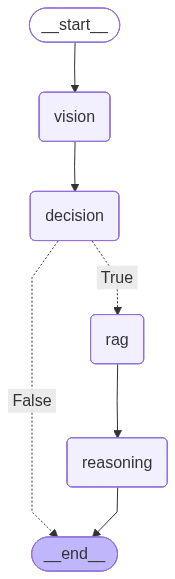

In [51]:
graph= StateGraph(CADState)

graph.add_node("vision", extract_features)
graph.add_node("decision", decide_topology)
graph.add_node("rag", retrieve_topology_rules)
graph.add_node("reasoning", generate_topology)

graph.set_entry_point("vision")

graph.add_edge("vision", "decision")
graph.add_conditional_edges(
    "decision",
    should_retrieve,{
        True: "rag",
        False: END
    }
)

graph.add_edge("rag", "reasoning")
graph.add_edge("reasoning", END)

app=graph.compile() 
app

In [52]:
result = app.invoke(
    {
        "image_path": "/Users/naswahmanandhar/Desktop/RAG/images/25.png"
    }
)

print("===== TOPOLOGY OUTPUT =====")
print(result["topology_output"])

with open("/Users/naswahmanandhar/Desktop/RAG/RAG topology result/25result.txt", "w") as f:
    f.write(result["topology_output"])
print("Topology JSON saved to topology_output.txt")

===== TOPOLOGY OUTPUT =====
<<<TOPOLOGY_START>>>
{
  "views": [
    {
      "view": "top",
      "outer_closed_loops": [
        {
          "loop_id": 1,
          "region": "MATERIAL",
          "nodes": 4,
          "edges": 4,
          "edge_type": {
            "straight": 4,
            "chamfer": 0,
            "arc": 0
          }
        }
      ],
      "inner_closed_loops": [
        {
          "loop_id": 2,
          "region": "VOID",
          "nodes": 4,
          "edges": 4,
          "edge_type": {
            "straight": 2,
            "arc": 2
          },
          "type": "Slot"
        },
        {
          "loop_id": 3,
          "region": "VOID",
          "nodes": 4,
          "edges": 4,
          "edge_type": {
            "straight": 2,
            "arc": 2
          },
          "type": "Slot"
        },
        {
          "loop_id": 4,
          "region": "VOID",
          "nodes": 0,
          "edges": 0,
          "type": "Circle"
        },
        {